<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Read in data</a></span><ul class="toc-item"><li><span><a href="#Get-original-input-stats" data-toc-modified-id="Get-original-input-stats-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get original input stats</a></span></li></ul></li><li><span><a href="#Convert-distance-to-meters" data-toc-modified-id="Convert-distance-to-meters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Convert distance to meters</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Reduction-of-number-of-fan-markings-to-finals" data-toc-modified-id="Reduction-of-number-of-fan-markings-to-finals-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Reduction of number of fan markings to finals</a></span></li></ul></li></ul></li><li><span><a href="#Length-stats" data-toc-modified-id="Length-stats-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Length stats</a></span><ul class="toc-item"><li><span><a href="#Blotch-sizes" data-toc-modified-id="Blotch-sizes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Blotch sizes</a></span></li><li><span><a href="#Longest-fans" data-toc-modified-id="Longest-fans-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Longest fans</a></span></li></ul></li><li><span><a href="#Regional" data-toc-modified-id="Regional-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Regional</a></span></li></ul></div>

In [1]:
%matplotlib nbagg

import seaborn as sns
from planet4 import io, stats, markings
from planet4.catalog_production import ReleaseManager

# Read in data

In [2]:
rm = ReleaseManager('v1.0b4')

In [3]:
db = io.DBManager()

In [10]:
db.n_image_names

42904

In [4]:
db.dbname

'/Users/klay6683/Dropbox/data/planet4/2017-12-31_planet_four_classifications_queryable_cleaned_seasons2and3.h5'

In [3]:
blotches = rm.read_blotch_file()
fans = rm.read_fan_file()

## Get original input stats

In [30]:
import dask.dataframe as dd

data = dd.read_hdf(db.dbname, 'df')

fan_input = data[data.marking=='fan']

blotch_input = data[data.marking=='blotch']

fan_input.compute().shape

blotch_input.compute().shape

# Convert distance to meters

In [4]:
fans['distance_m'] = fans.distance*fans.map_scale

blotches['radius_1_m'] = blotches.radius_1*blotches.map_scale
blotches['radius_2_m'] = blotches.radius_2*blotches.map_scale

### Reduction of number of fan markings to finals

In [26]:
n_fan_in = 2792963

In [24]:
fans.shape[0]

159288

In [27]:
fans.shape[0] / n_fan_in

0.05703190482652294

In [28]:
blotches.shape[0]

250355

# Length stats

Percentage of fan markings below 100 m:

In [7]:
import scipy
scipy.stats.percentileofscore(fans.distance_m, 100)

96.597358244186623

Cumulative histogram of fan lengths

In [8]:
def add_percentage_line(ax, meters, column):
    y = scipy.stats.percentileofscore(column, meters)
    ax.axhline(y/100)
    ax.axvline(meters)
    ax.text(meters, y/100, f"{y/100:0.2f}")

In [9]:
plt.close('all')

<IPython.core.display.Javascript object>


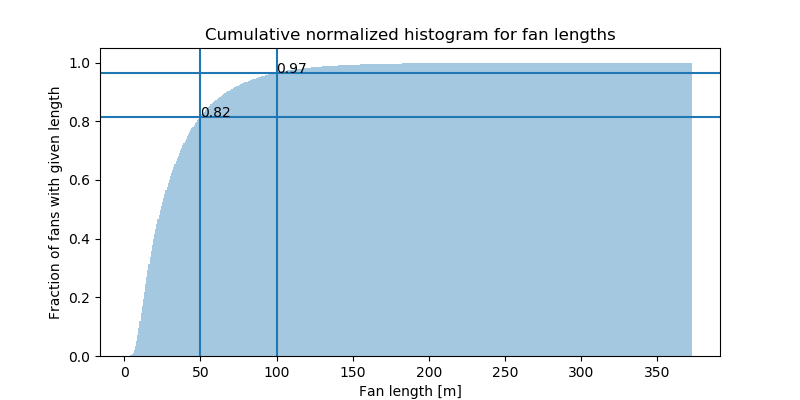

In [10]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(fans.distance_m, bins=500, kde=False, hist_kws={'cumulative':True,'normed':True},
            axlabel='Fan length [m]', ax=ax)
ax.set_title("Cumulative normalized histogram for fan lengths")
ax.set_ylabel("Fraction of fans with given length")
add_percentage_line(ax, 100, fans.distance_m)
add_percentage_line(ax, 50, fans.distance_m)

General fan stats, in numbers

In [11]:
fans.distance_m.describe()

count    159288.000000
mean         33.110840
std          28.040346
min           2.500000
25%          14.497064
50%          24.087729
75%          41.884256
max         372.821750
Name: distance_m, dtype: float64

In words, the mean length of fans is {{f"{fans.distance_m.describe()['mean']:.1f}"}} m, while the median is
{{f"{fans.distance_m.describe()['50%']:.1f}"}} m.

## Blotch sizes

<IPython.core.display.Javascript object>


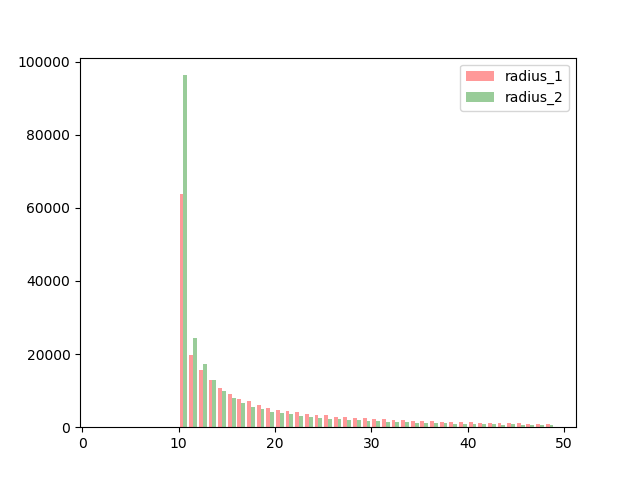

In [41]:
plt.figure()
cols = ['radius_1','radius_2']
sns.distplot(blotches[cols], kde=False, bins=np.arange(2.0,50.), 
             color=['r','g'], label=cols)
plt.legend()

In [94]:
plt.figure()
cols = ['radius_1_m','radius_2_m']
sns.distplot(blotches[cols], kde=False, bins=np.arange(2.0,50.), 
             color=['r','g'], label=cols)
plt.legend()

FigureCanvasNbAgg()

<IPython.core.display.Javascript object>


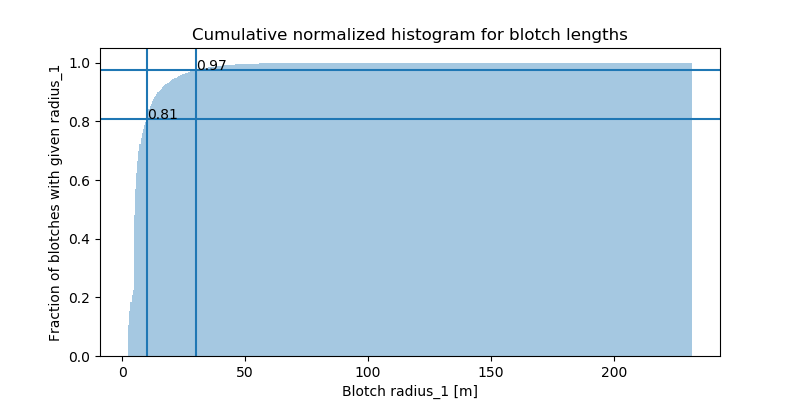

In [42]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(blotches.radius_2_m, bins=500, kde=False, hist_kws={'cumulative':True,'normed':True},
            axlabel='Blotch radius_1 [m]', ax=ax)
ax.set_title("Cumulative normalized histogram for blotch lengths")
ax.set_ylabel("Fraction of blotches with given radius_1")
add_percentage_line(ax, 30, blotches.radius_2_m)
add_percentage_line(ax, 10, blotches.radius_2_m)

In [43]:
import scipy
scipy.stats.percentileofscore(blotches.radius_2_m, 30)

97.428851031535231

In [144]:
plt.close('all')

## Longest fans

In [44]:
fans.query('distance_m > 350')[
    'distance_m distance obsid image_x image_y image_id x_tile y_tile'.split()].sort_values(
        by='distance_m')

,distance_m,distance,obsid,image_x,image_y,image_id,x_tile,y_tile
113541,351.363719,351.363719,ESP_020146_0950,791.238892,12659.666667,APF0000q45,1.0,23.0
123488,360.917689,721.835379,ESP_011961_0935,782.777778,9321.291667,APF0000ddo,2.0,18.0
123543,367.916840,735.833681,ESP_011961_0935,868.666667,5188.521739,APF0000de3,2.0,10.0
156640,372.821750,745.643501,ESP_013095_0935,1017.125000,6038.916667,APF0000dtk,2.0,12.0


In [53]:
users1 = markings.ImageID("APF0000dtk").data.user_name.unique()

In [54]:
users2 = markings.ImageID("de3").data.user_name.unique()

In [58]:
same = []
for user in users1:
    if user in users2:
        same.append(user)

In [59]:
same

['Paul Johnson']

In [61]:
len(users2)

54

In [45]:
from planet4 import plotting

In [161]:
plotting.plot_image_id_pipeline('q45', datapath=rm.catalog, via_obsid=False, figsize=(12,8))

FigureCanvasNbAgg()

# Regional 

In [5]:
from planet4 import stats
from planet4 import region_data

In [6]:
stats.define_season_column(fans)
stats.define_season_column(blotches)

In [12]:
regions = ['Manhattan2', 'Giza', 'Inca', 'Ithaca']

In [98]:
for reg in regions:
    obj = getattr(region_data, reg)
    roi = obj()
    for marking in [fans, blotches]:
        if reg == 'Manhattan2':
            reg = 'Manhattan'
        marking.loc[marking.obsid.isin(roi.all_obsids), 'roi'] = reg

In [14]:
fans.roi.value_counts(dropna=False)

NaN           107800
Ithaca         23965
Inca           11207
Manhattan2     10050
Giza            6266
Name: roi, dtype: int64

In [99]:
fans_rois = fans[fans.roi.notnull()]
blotches_rois = blotches[blotches.roi.notnull()]

In [100]:
fans_rois.roi.value_counts(dropna=False)

Ithaca       23965
Inca         11207
Manhattan    10050
Giza          6266
Name: roi, dtype: int64

In [52]:
fans.query('season==2').distance_m.median()

24.222173790536814

In [53]:
fans.query('season==3').distance_m.median()

23.816898558177456

In [62]:
import seaborn as sns
sns.set_palette('Set1')

In [ ]:
fans_rois

In [96]:
def my_plot(x, **kwargs):
    sns.distplot(x, kde=True, **kwargs)
#     plt.axvline(x.median(), color='blue')
    plt.gca().set_xlim(-10, 150)

<IPython.core.display.Javascript object>


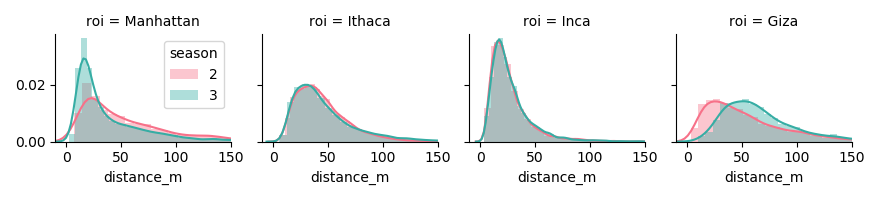

In [101]:
g = sns.FacetGrid(fans_rois, col="roi", hue='season', size=2, aspect=1.1, legend_out=False)
# g.map(sns.distplot, "distance_m", kde=True);
g.map(my_plot, 'distance_m')
g.add_legend()

<IPython.core.display.Javascript object>


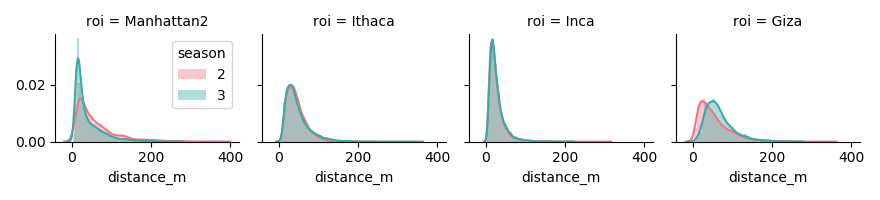

In [78]:
g = sns.FacetGrid(fans_rois, col="roi", hue='season', size=2, aspect=1.1, legend_out=False)
g.map(sns.distplot, "distance_m", kde=True);
# g.map(my_plot, 'distance_m')
g.add_legend()

In [176]:
for region in ['Manhattan2', 'Giza','Ithaca']:
    print(region)
    obj = getattr(region_data, region)
    for s in ['season2','season3']:
        print(s)
        obsids = getattr(obj, s)
        print(fans[fans.obsid.isin(obsids)].distance_m.median())

Manhattan2
season2
42.22955914615964
season3
24.620967870382735
Giza
season2
43.805752235595186
season3
58.74001938202725
Ithaca
season2
39.451376093349495
season3
38.6165230309949


<IPython.core.display.Javascript object>


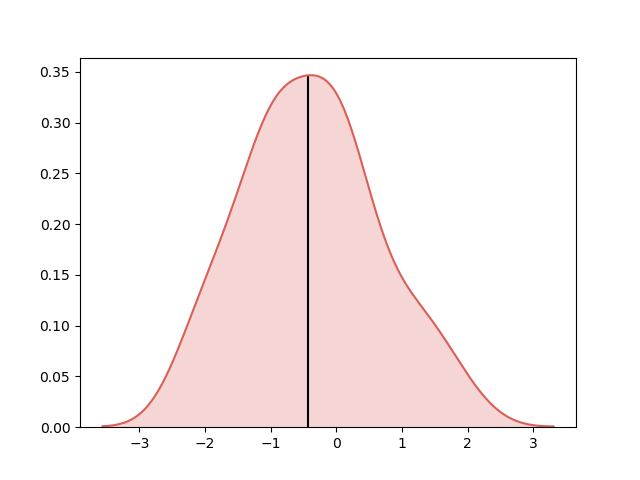

In [67]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()

sns.set_palette("hls", 1)
data = np.random.randn(30)
p=sns.kdeplot(data, shade=True)

x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)

<IPython.core.display.Javascript object>


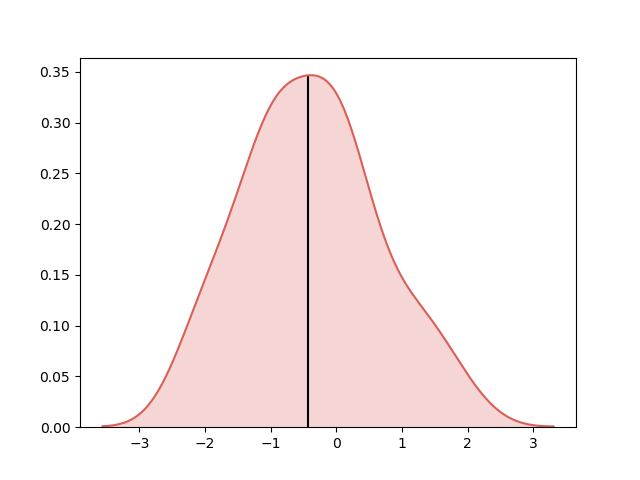

In [67]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()

sns.set_palette("hls", 1)
data = np.random.randn(30)
p=sns.kdeplot(data, shade=True)

x,y = p.get_lines()[0].get_data()

#care with the order, it is first y
#initial fills a 0 so the result has same length than x
cdf = scipy.integrate.cumtrapz(y, x, initial=0)

nearest_05 = np.abs(cdf-0.5).argmin()

x_median = x[nearest_05]
y_median = y[nearest_05]

plt.vlines(x_median, 0, y_median)

In [69]:
np.median(x)

-0.12795252889867426

In [71]:
np.percentile(x, 50)

-0.12795252889867426